In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os
import numpy
from scipy.misc import logsumexp
import tqdm
import pickle
import hom2m
from galpy.util import bovy_plot, save_pickles
%pylab inline
from matplotlib import cm
from matplotlib.ticker import FuncFormatter
numpy.random.seed(3)
import copy
import matplotlib.animation as animation
from matplotlib import gridspec
from IPython.display import HTML, Image
import seaborn as sns
tc= sns.color_palette('colorblind')
init_color= sns.color_palette()[0]
final_color= tc[2]
constraint_color= tc[1]
save_figures= False

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib
/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))



# Harmonic-oscillator M2M modeling of the *TGAS* F-type star data

## Observations

First we load the (a) density measurements corrected for the *TGAS* selection and (b) the measurements of $\langle v_z^2\rangle$ from the *TGAS* data alone.

Density measurements look like this:

In [3]:
# Restore the density fits to entire stellar population bins
with open('counts_vert_AthroughF_10bins_wext.sav','rb') as savefile:
    all_counts= pickle.load(savefile)
    all_counts_unc= pickle.load(savefile)
    all_effvol= pickle.load(savefile)
all_counts= all_counts[:,:,0]
all_counts_unc= all_counts_unc[:,:,0]
all_effvol= all_effvol[:,:,0]
zbins= numpy.arange(-0.4125,0.425,0.025)
ii= 1 # F stars come 2nd after A stars
c= all_counts[ii]
ec= all_counts_unc[ii]
raw= c*all_effvol[ii] # recover the raw counts
ef= all_effvol[ii]/(0.2**2.*numpy.pi*(zbins[1]-zbins[0])) # this is the effective completeness
good_dens_indx= (ef > 0.03*numpy.nanmax(ef))*(c > 0.)*((ef == ef[len(ef)//2])+(ef > 10.**-5.))*(raw > 4.)
# Load into format for HOM2M
z_obs= 0.5*(numpy.roll(zbins,-1)+zbins)[:-1]
dens_obs= c[good_dens_indx]/10.**9. # --> /pc^3
dens_obs_noise= ec[good_dens_indx]/10.**9. # --> /pc^3

<Container object of 3 artists>

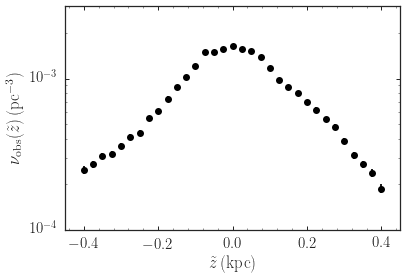

In [4]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,dens_obs,'ko',semilogy=True,
                   xlabel=r'$\tilde{z}\,(\mathrm{kpc})$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})\,(\mathrm{pc}^{-3})$',
                   xrange=[-.45,0.45],yrange=[0.0001,0.003])
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color='k')

The $\langle v_z^2\rangle$ measurements look as follows

In [5]:
savefilename= 'Fstar-sigz.sav'
with open(savefilename,'rb') as savefile:
    out= (pickle.load(savefile),)
    while True:
        try:
            out= out+(pickle.load(savefile),)
        except EOFError:
            break
zbins,sig2z,sig2z_err,nstar,all_sam,ngauss,nboot,start= out
# Load into format for HOM2M
v2_obs= sig2z
v2_obs_noise= sig2z_err
# Setting these to NaN should be fine with the HOM2M algorithm
v2_obs[numpy.fabs(z_obs) > 0.198]= numpy.nan
v2_obs_noise[numpy.fabs(z_obs) > 0.198]= numpy.nan

<Container object of 3 artists>

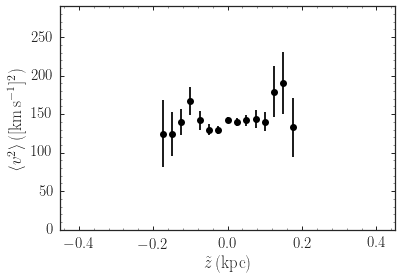

In [6]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,v2_obs,'ko',
                   xlabel=r'$\tilde{z}\,(\mathrm{kpc})$',ylabel=r'$\langle v^2\rangle\,([\mathrm{km\,s}^{-1}]^2)$',
                   xrange=[-.45,0.45],yrange=[0.0,290.],gcf=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color='k')

## Fit weights, $z_\odot$, and $\omega$ simultaneously

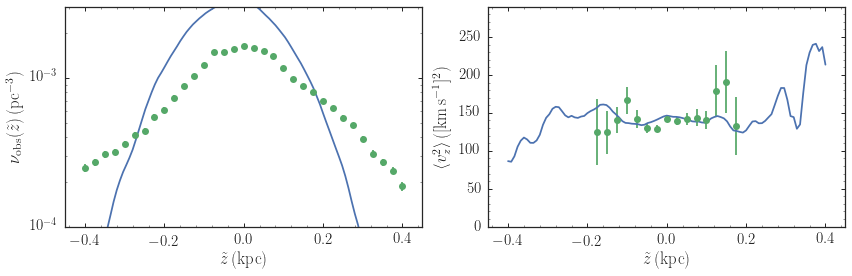

In [7]:
n_m2m= 10000
sigma_init= 12. # km/s
omega_m2m= 100. # km/s/kpc
zsun_m2m= 0.025 # pc
h_m2m= 0.035 # kpc
z_m2m, vz_m2m= hom2m.sample_iso(sigma_init,omega_m2m,n=n_m2m)
w_init= numpy.ones(n_m2m)/float(n_m2m)/1000.
z_out= numpy.linspace(-0.4,0.4,101)
dens_init= hom2m.compute_dens(z_m2m,zsun_m2m,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_m2m,z_out,h_m2m,w=w_init)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,gcf=True,
                   xlabel=r'$\tilde{z}\,(\mathrm{kpc})$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})\,(\mathrm{pc}^{-3})$',
                   xrange=[-.45,0.45],yrange=[0.0001,0.003])
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(1,2,2)
bovy_plot.bovy_plot(z_out,v2_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}\,(\mathrm{kpc})$',ylabel=r'$\langle v_z^2\rangle\,([\mathrm{km\,s}^{-1}]^2)$',
                   xrange=[-.45,0.45],yrange=[0.0,290.])
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
#yscale('log',nonposy='clip')
tight_layout()

In [8]:
step= numpy.pi/3.*10.**-4.
nstep= 30000
eps= [10.**-5.5,10.**-5.,10.**2.]
smooth= None
st96smooth= False
mu= 0.
#omega_m2m= set in previous cell
fit_zsun= True
fit_omega= True
use_v2= True
skipomega= 10
delta_omega= 30.
prior= 'entropy'
maxz= 0.448
w_out,zsun_out,omega_out,z_final, vz_final, Q,wevol,windx=\
        hom2m.fit_m2m(w_init,z_m2m,vz_m2m,omega_m2m,zsun_m2m,
                      z_obs[numpy.fabs(z_obs) < maxz],
                      dens_obs[numpy.fabs(z_obs) < maxz],
                      dens_obs_noise[numpy.fabs(z_obs) < maxz],
                      v2_obs[numpy.fabs(z_obs) < maxz],
                      v2_obs_noise[numpy.fabs(z_obs) < maxz],
                      use_v2=use_v2,
                      nstep=nstep,step=step,mu=mu,eps=eps,
                      h_m2m=h_m2m,prior=prior,
                      smooth=smooth,st96smooth=st96smooth,
                      output_wevolution=10,
                      fit_omega=fit_omega,skipomega=skipomega,delta_omega=delta_omega,
                      fit_zsun=fit_zsun)

('Velocity dispersions: fit', 12.245594925596507)
('omega: best-fit', 69.800954171290115)
('zsun: best-fit', -0.00030676211611743172)


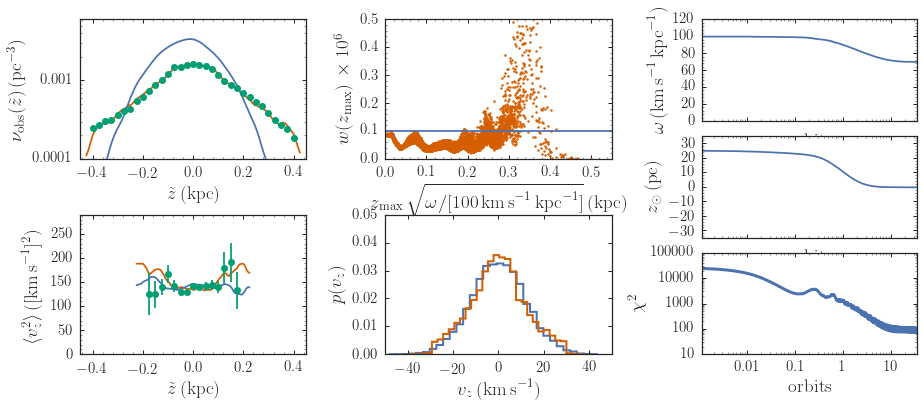

In [9]:
A_m2m, phi_m2m= hom2m.zvz_to_Aphi(z_final,vz_final,omega_out[-1])
A_init, phi_init= hom2m.zvz_to_Aphi(z_m2m,vz_m2m,omega_m2m)
z_out= numpy.linspace(-0.425,0.425,101)
dens_init= hom2m.compute_dens(z_m2m,zsun_m2m,z_out,h_m2m,w=w_init)
z_out_v2= numpy.linspace(-0.225,0.225,101)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_m2m,z_out_v2,h_m2m,w=w_init)
dens_final= hom2m.compute_dens(z_final,zsun_out[-1],z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_final,vz_final,zsun_out[-1],z_out_v2,h_m2m,w=w_out)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
gs= gridspec.GridSpec(2,3,hspace=0.4,wspace=0.35)
gs2= gridspec.GridSpec(3,3,hspace=0.15,wspace=0.45)
subplot(gs[0])
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}\,(\mathrm{kpc})$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})\,(\mathrm{pc}^{-3})$',
                   xrange=[-.45,0.45],yrange=[0.0001,0.006],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(gs[3])
bovy_plot.bovy_plot(z_out_v2,v2_init,'-',color=init_color,
                   xlabel=r'$\tilde{z}\,(\mathrm{kpc})$',ylabel=r'$\langle v_z^2\rangle\,([\mathrm{km\,s}^{-1}]^2)$',
                   xrange=[-.45,0.45],yrange=[0.0,290.],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out_v2,v2_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
subplot(gs[1])
bovy_plot.bovy_plot(A_m2m*numpy.sqrt(omega_out[-1]/100.),w_out*10.**6.,'k.',ms=5.,color=final_color,
                    xlabel=r'$z_{\mathrm{max}}\,\sqrt{\omega/[100\,\mathrm{km\,s}^{-1}\,\mathrm{kpc}^{-1}]}\,(\mathrm{kpc})$',
                    ylabel=r'$w(z_{\mathrm{max}})\,\times 10^6$',
                   yrange=[0.,5.*w_init[0]*10.**6.],xrange=[0.,0.55],gcf=True)
axhline(w_init[0]*10.**6.,color=init_color,)
subplot(gs[4])
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
_= hist(vz_final,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color)
xlim(-50.,50.)
ylim(0.,0.05)
xlabel(r'$v_z\,(\mathrm{km\,s}^{-1})$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: fit",\
      numpy.sqrt(numpy.sum(w_out*(vz_final-numpy.sum(w_out*vz_final)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
subplot(gs2[0,2])
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*numpy.median(omega_out)/2./numpy.pi,omega_out,'-',
                    color=sns.color_palette()[0],
                    yrange=[0.,120.],
                    semilogx=True,xlabel=r'$\mathrm{orbits}$',
                    ylabel=r'$\omega\,(\mathrm{km\,s}^{-1}\,\mathrm{kpc}^{-1})$',gcf=True)
print("omega: best-fit",omega_out[-1])
#gca().xaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(NullFormatter())
subplot(gs2[1,2])
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*numpy.median(omega_out)/2./numpy.pi,
                    1000.*zsun_out,'-',
                    color=sns.color_palette()[0],
                    yrange=[-35,35],
                    semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$z_\odot\,(\mathrm{pc})$',gcf=True)
print("zsun: best-fit",zsun_out[-1])
#gca().xaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(NullFormatter())
subplot(gs2[2,2])
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*numpy.median(omega_out)/2./numpy.pi,
                    numpy.nansum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[10.,10**5.])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))

## MCMC sample all parameters

In [10]:
savefilename= 'fstar_data_v2.sav' 
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        out= (pickle.load(savefile),)
        while True:
            try:
                out= out+(pickle.load(savefile),)
            except EOFError:
                break
    w_out,z_final,vz_final,omega_out,zsun_out,z_obs,dens_obs,dens_obs_noise,v2_obs,v2_obs_noise,w_init= out
else:
    save_pickles(savefilename,w_out,z_final,vz_final,omega_out,zsun_out,
                z_obs,dens_obs,dens_obs_noise,v2_obs,v2_obs_noise,w_init)

In [11]:
step_sam= step
nstep_sam= nstep
eps_sam= eps[0]
nsamples= 100
fit_omega= True
sig_omega= 3. # proposal step
nstep_omega= 1000
nmh_omega= 10
nstepadfac_omega= 10
fit_zsun= True
sig_zsun= 0.007
nstep_zsun= 500
nmh_zsun= 20
s_low, s_high= 16,-16
use_v2=True
fix_weights= False
savefilename= 'fstar_sam_v2.sav'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        out= (pickle.load(savefile),)
        while True:
            try:
                out= out+(pickle.load(savefile),)
            except EOFError:
                break
else:
    out= hom2m.sample_m2m(nsamples,w_out,z_final,vz_final,omega_out[-1],zsun_out[-1],
                          z_obs[numpy.fabs(z_obs) < maxz],
                          dens_obs[numpy.fabs(z_obs) < maxz],
                          dens_obs_noise[numpy.fabs(z_obs) < maxz],
                          densv2_obs=v2_obs[numpy.fabs(z_obs) < maxz],
                          densv2_obs_noise=v2_obs_noise[numpy.fabs(z_obs) < maxz],
                          use_v2=use_v2,fix_weights=fix_weights,
                          nstep=nstep_sam,step=step_sam,eps=eps_sam,
                          mu=mu,h_m2m=h_m2m,prior=prior,w_prior=w_init,
                          smooth=smooth,st96smooth=st96smooth,
                          fit_omega=fit_omega,sig_omega=sig_omega,nstep_omega=nstep_omega,nmh_omega=nmh_omega,
                          nstepadfac_omega=nstepadfac_omega,
                          fit_zsun=fit_zsun,sig_zsun=sig_zsun,nstep_zsun=nstep_zsun,nmh_zsun=nmh_zsun)
    save_pickles(savefilename,*out)
w_sam,zsun_sam,omega_sam,Q_sam,z_sam,vz_sam= out

The chain:

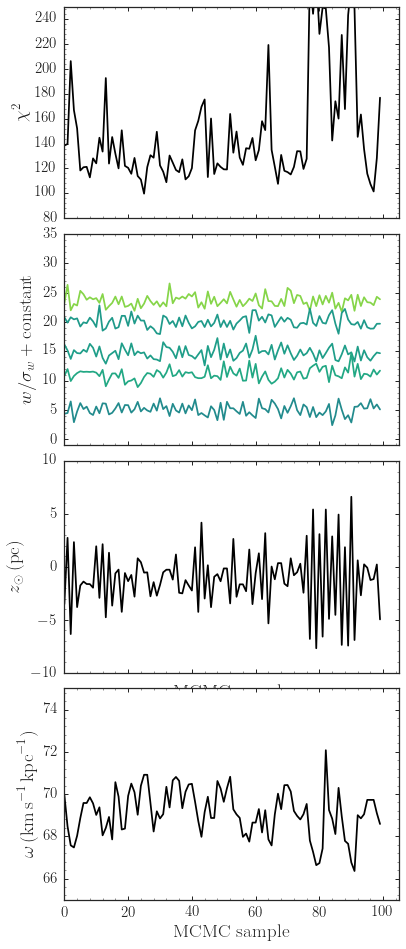

In [12]:
A_m2m_sam, _= hom2m.zvz_to_Aphi(z_sam[0],vz_sam[0],omega_sam[0]) # Make sure to lign up A_m2m and sampling orbits
figsize(6,16)
gs= gridspec.GridSpec(4,1,hspace=0.075,wspace=0.0)
subplot(gs[0])
bovy_plot.bovy_plot(numpy.nansum(Q_sam,axis=1),gcf=True,color='k',
                   ylabel=r'$\chi^2$',
                   xrange=[0.,nsamples*1.05],
                   yrange=[80.,250.])
gca().xaxis.set_major_formatter(NullFormatter())
subplot(gs[1])
nran= 5
rndindx= numpy.random.permutation(len(w_sam[0]))[:nran-1]
# Add a weight near in A_m2m to the weight with the 2nd largest A_m2m
medA= A_m2m_sam[rndindx][numpy.argsort(A_m2m_sam[rndindx])[-3]]
newi= numpy.argmin(numpy.fabs(A_m2m_sam-medA+0.005))
rndindx= list(rndindx)
rndindx.append(newi)
rndindx= numpy.array(rndindx,dtype='int')
sindx= numpy.argsort(numpy.argsort(numpy.nanmean(w_sam[:,rndindx],axis=0)))
for ii,jj in enumerate(rndindx):
    bovy_plot.bovy_plot(w_sam[:,jj]/numpy.nanstd(w_sam[:,jj])+5*sindx[ii],'-',
                        color=cm.viridis(A_m2m_sam[jj]*numpy.sqrt(omega_out[0]/100.)/.3),
                        xrange=[0.,nsamples*1.05],
                        yrange=[-1,35],
                        ylabel=r'$w/\sigma_w+\mathrm{constant}$',gcf=True,overplot=ii>0)
gca().xaxis.set_major_formatter(NullFormatter())
subplot(gs[2])
bovy_plot.bovy_plot(zsun_sam*1000.,gcf=True,color='k',
                    xlabel=r'$\mathrm{MCMC\ sample}$',
                    ylabel=r'$z_\odot\,(\mathrm{pc})$',
                    xrange=[0.,nsamples*1.05],
                    yrange=[-10.,10.])
gca().xaxis.set_major_formatter(NullFormatter())
subplot(gs[3])
bovy_plot.bovy_plot(omega_sam,gcf=True,color='k',
                    xlabel=r'$\mathrm{MCMC\ sample}$',
                    ylabel=r'$\omega\,(\mathrm{km\,s}^{-1}\,\mathrm{kpc}^{-1})$',
                    xrange=[0.,nsamples*1.05],
                    yrange=[65.,75.])

('Velocity dispersions: mock, fit, mean of samples (unc.)', 12.245594925596507, 12.251668725366788, 0.13422795588688749)
('omega: best-fit, mean of samples unc.)', 69.800954171290115, 69.119981465628584, 1.0847579907145488)
('zsun: best-fit, mean of samples unc.)', -0.3067621161174317, -1.1186383824903379, 2.8809254448506545)


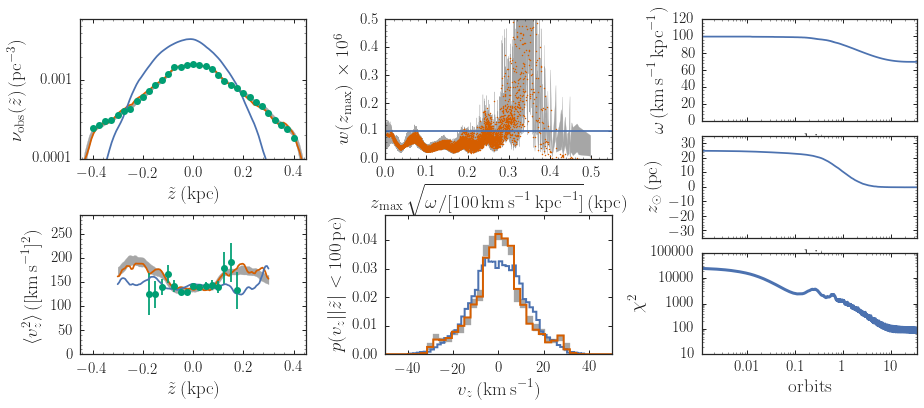

In [13]:
A_m2m, phi_m2m= hom2m.zvz_to_Aphi(z_final,vz_final,omega_out[-1])
A_init, phi_init= hom2m.zvz_to_Aphi(z_m2m,vz_m2m,omega_m2m)
z_out= numpy.linspace(-0.45,0.45,101)
dens_init= hom2m.compute_dens(z_m2m,zsun_m2m,z_out,h_m2m,w=w_init)
z_out_v2= numpy.linspace(-0.3,0.3,101)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_m2m,z_out_v2,h_m2m,w=w_init)
dens_final= hom2m.compute_dens(z_final,zsun_out[-1],z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_final,vz_final,zsun_out[-1],z_out_v2,h_m2m,w=w_out)
# density and densv2 for samples
dens_final_sam= numpy.empty((nsamples,len(dens_final)))
v2_final_sam= numpy.empty((nsamples,len(dens_final)))
vz_hist= numpy.empty((nsamples,51))
sigvz= numpy.empty((nsamples))
for ii in range(nsamples):
    dens_final_sam[ii]= hom2m.compute_dens(z_sam[ii],zsun_sam[ii],z_out,h_m2m,w=w_sam[ii])
    v2_final_sam[ii]= hom2m.compute_v2(z_sam[ii],vz_sam[ii],zsun_sam[ii],z_out_v2,h_m2m,w=w_sam[ii])
    vz_hist[ii], _= numpy.histogram(vz_sam[ii][numpy.fabs(z_sam[ii]) < 0.1],
                                    weights=w_sam[ii][numpy.fabs(z_sam[ii]) < 0.1],normed=True,bins=51,range=[-70.,70.])
    sigvz[ii]= numpy.sqrt(numpy.nansum(w_sam[ii]*(vz_sam[ii]\
                            -numpy.nansum(w_sam[ii]*vz_sam[ii])/numpy.nansum(w_sam[ii]))**2.)/numpy.nansum(w_sam[ii]))
dens_final_sam_sorted= numpy.sort(dens_final_sam,axis=0)
v2_final_sam_sorted= numpy.sort(v2_final_sam,axis=0)
w_sam_sorted= numpy.sort(w_sam,axis=0)
vz_hist_sorted= numpy.sort(vz_hist,axis=0)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
gs= gridspec.GridSpec(2,3,hspace=0.4,wspace=0.35)
gs2= gridspec.GridSpec(3,3,hspace=0.15,wspace=0.45)
subplot(gs[0])
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}\,(\mathrm{kpc})$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})\,(\mathrm{pc}^{-3})$',
                   xrange=[-.45,0.45],yrange=[0.0001,0.006],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
fill_between(z_out,dens_final_sam_sorted[s_low],dens_final_sam_sorted[s_high],color='0.65',zorder=0)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(gs[3])
bovy_plot.bovy_plot(z_out_v2,v2_init,'-',color=init_color,
                   xlabel=r'$\tilde{z}\,(\mathrm{kpc})$',ylabel=r'$\langle v_z^2\rangle\,([\mathrm{km\,s}^{-1}]^2)$',
                   xrange=[-.45,0.45],yrange=[0.0,290.],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out_v2,v2_final,'-',overplot=True,zorder=0,color=final_color)
fill_between(z_out_v2,v2_final_sam_sorted[s_low],v2_final_sam_sorted[s_high],color='0.65',zorder=0)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
subplot(gs[1])
bovy_plot.bovy_plot(A_m2m*numpy.sqrt(omega_out[-1]/100.),w_out*10.**6.,'k.',ms=3.,color=final_color,
                    xlabel=r'$z_{\mathrm{max}}\,\sqrt{\omega/[100\,\mathrm{km\,s}^{-1}\,\mathrm{kpc}^{-1}]}\,(\mathrm{kpc})$',
                    ylabel=r'$w(z_{\mathrm{max}})\,\times 10^6$',
                   yrange=[0.,5.*w_init[0]*10.**6.],xrange=[0.,0.55],gcf=True)
axhline(w_init[0]*10.**6.,color=init_color,)
sindx= numpy.argsort(A_m2m_sam*numpy.sqrt(omega_sam[0])) # might have changed due to pickling
fill_between(A_m2m_sam[sindx]*numpy.sqrt(omega_sam[0]/100.),
             10.**6.*w_sam_sorted[s_low][sindx],
             10.**6.*w_sam_sorted[s_high][sindx],color='0.65',zorder=0)
subplot(gs[4])
_= hist(vz_m2m[[numpy.fabs(z_m2m) < 0.1]],histtype='step',lw=2.,normed=True,bins=51,zorder=0,color=init_color)
h,e,p= hist(vz_final[numpy.fabs(z_final) < 0.1],
            weights=w_out[numpy.fabs(z_final) < 0.1],
            histtype='step',lw=2.,normed=True,bins=51,zorder=1,color=final_color,
            range=[-70.,70.])
fill_between(0.5*(e+numpy.roll(e,1))[1:],vz_hist_sorted[s_low],vz_hist_sorted[s_high],color='0.65',zorder=0,step='mid')
xlim(-50.,50.)
ylim(0.,0.049)
xlabel(r'$v_z\,(\mathrm{km\,s}^{-1})$')
ylabel(r'$p(v_z||\tilde{z}| < 100\,\mathrm{pc})$')
print("Velocity dispersions: mock, fit, mean of samples (unc.)",\
      numpy.sqrt(numpy.sum(w_out*(vz_final-numpy.sum(w_out*vz_final)/numpy.sum(w_out))**2.)/numpy.sum(w_out)),
      numpy.nanmean(sigvz),
      numpy.nanstd(sigvz))
print("omega: best-fit, mean of samples unc.)",omega_out[-1],numpy.mean(omega_sam),numpy.std(omega_sam))
subplot(gs2[0,2])
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*numpy.median(omega_out)/2./numpy.pi,omega_out,'-',
                    color=sns.color_palette()[0],
                    yrange=[0.,120.],
                    semilogx=True,xlabel=r'$\mathrm{orbits}$',
                    ylabel=r'$\omega\,(\mathrm{km\,s}^{-1}\,\mathrm{kpc}^{-1})$',gcf=True)
gca().xaxis.set_major_formatter(NullFormatter())
subplot(gs2[1,2])
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*numpy.median(omega_out)/2./numpy.pi,
                    1000.*zsun_out,'-',
                    color=sns.color_palette()[0],
                    yrange=[-35,35],
                    semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$z_\odot\,(\mathrm{pc})$',gcf=True)
print("zsun: best-fit, mean of samples unc.)",zsun_out[-1]*1000.,1000.*numpy.mean(zsun_sam),1000.*numpy.std(zsun_sam))
gca().xaxis.set_major_formatter(NullFormatter())
subplot(gs2[2,2])
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*numpy.median(omega_out)/2./numpy.pi,
                    numpy.nansum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[10.,10**5.])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2017-hom2m','fstar_m2m.pdf'),
                bbox_inches='tight')